In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re, traceback
import numpy as np
from shutil import copyfile
from datetime import datetime
from fuzzywuzzy import process
import easyocr

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
import rasterio as rio

# IMAGE IMPORTS
# from skimage.morphology import skeletonize
# from skimage import img_as_bool, img_as_ubyte


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *
from TileNameFinder import *
from ReadDate import *
from featurematching import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

c:\Users\fhacesga\Anaconda3\envs\yolo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\fhacesga\AppData\Local\Temp\ipykernel_32916\1811205482.py:17: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. 

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [2]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\RECTDNN\uncompress_2\\"
    base_output_path  = r"D:\RECTDNN\processing\\"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
    tiled_yolo_model_paths = [
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt",
        r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt"
    ]
elif username == 'fhace':
    base_input_path   = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    # dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

In [3]:
CLNN=None

In [4]:
image = cv2.imread(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CLNN\val\48071CIND0A.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
countyArea, CLNN    = findCounty(image, model=CLNN, **dnn_params['CLNN'])

In [6]:
image_curr = cv2.resize(cv2.erode(image,np.ones((5, 5), np.uint8)),(0, 0), fx = 0.1, fy = 0.1) 
countyArea_curr     = cv2.resize(countyArea,(0, 0), fx = 0.1, fy = 0.1) 

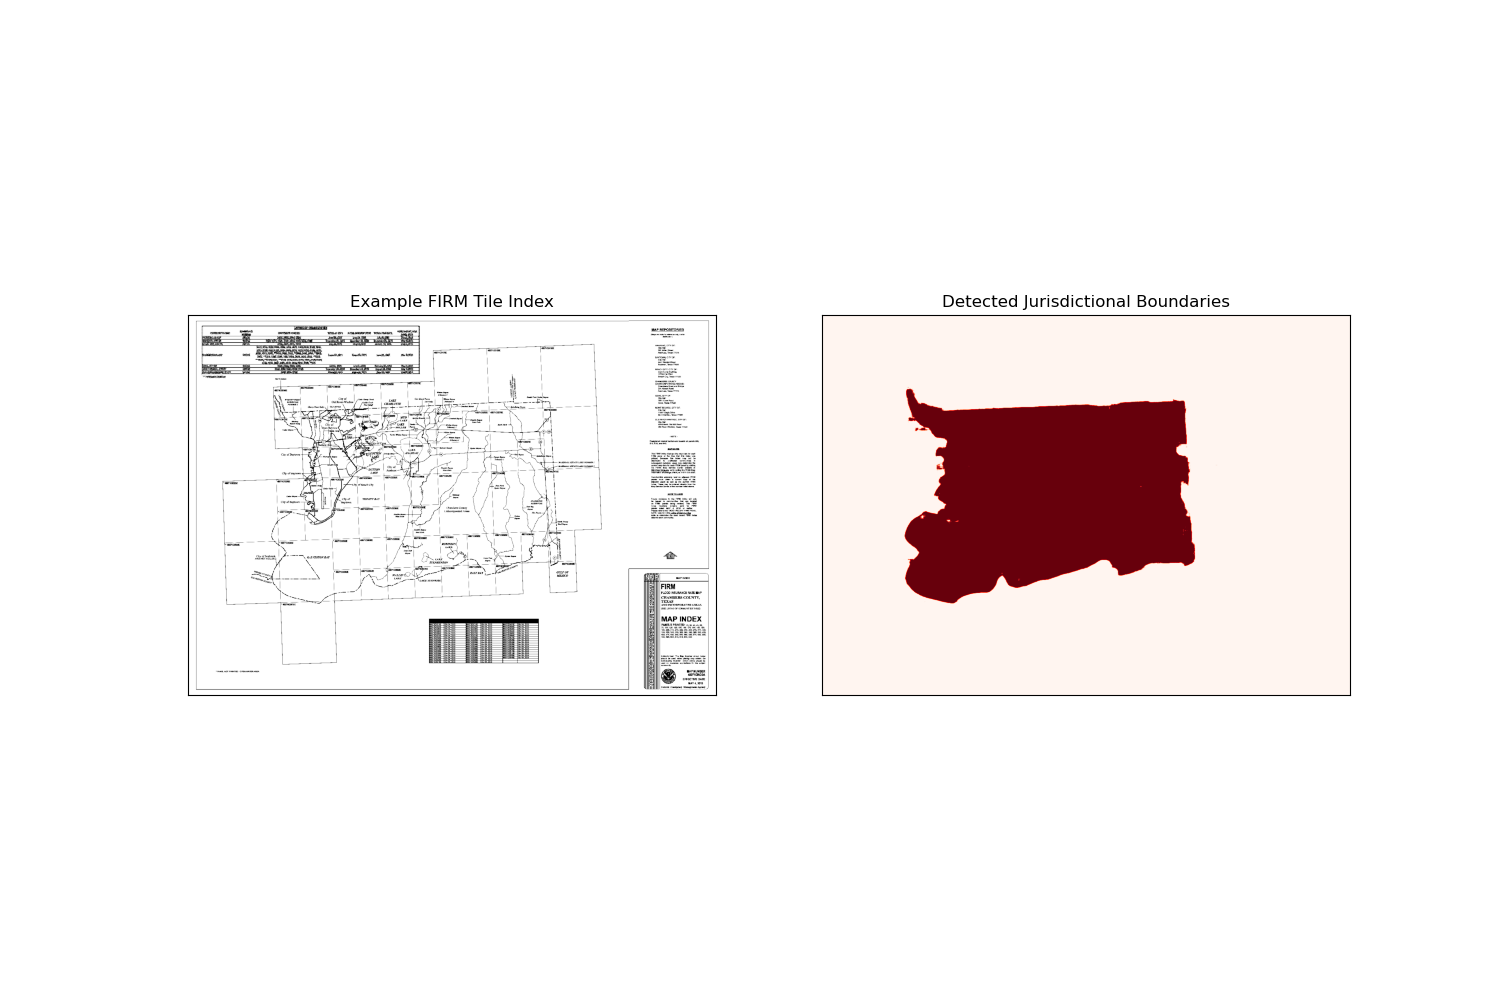

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image_curr, cmap="Greys_r")
axs[1].imshow(countyArea_curr[:,:,0], vmin=0, vmax=255, cmap='Reds_r')

axs[0].set_title("Example FIRM Tile Index")
axs[1].set_title("Detected Jurisdictional Boundaries")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

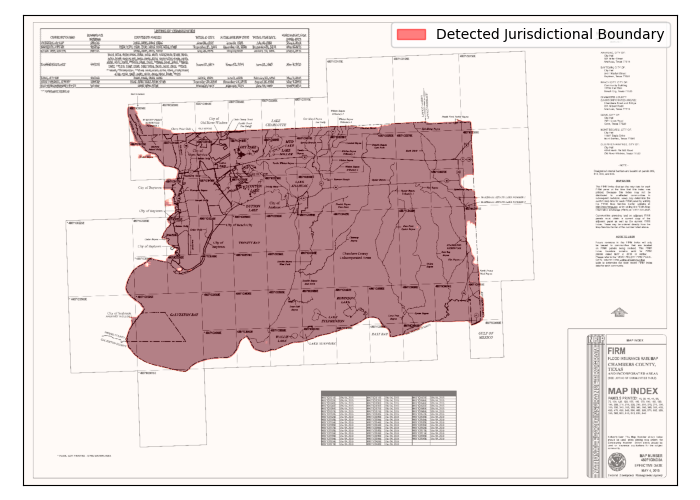

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7, 5),)

# Show base image
ax.imshow(image_curr, cmap="Greys_r")

# Overlay the jurisdictional boundaries with transparency
ax.imshow(countyArea_curr[:, :, 0], vmin=0, vmax=255, cmap='Reds_r', alpha=0.5)

# Title and clean axes
ax.set_xticks([])
ax.set_yticks([])

# Legend
red_patch = mpatches.Patch(color='red', label='Detected Jurisdictional Boundary', alpha=0.5)
ax.legend(handles=[red_patch], loc='upper right')

plt.tight_layout()
plt.show()


In [9]:
len(torch.nn.utils.parameters_to_vector(CLNN.parameters()))

23488317

In [10]:
checkpoint = torch.load(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CLNN\checkpoint_101423.pth")

In [11]:
IOU_train = np.stack(checkpoint['iou_lists']['train'])
IOU_val = np.stack(checkpoint['iou_lists']['test'])

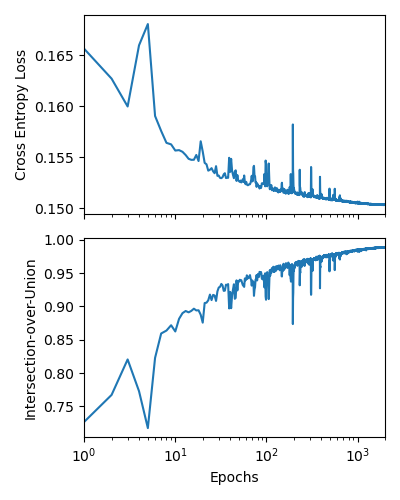

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 5))

axs[0].plot(checkpoint['epoch_losses']['train'])

axs[1].plot(IOU_train[:, 1])
axs[1].set_xlabel("Epochs")
axs[0].set_ylabel("Cross Entropy Loss")
axs[1].set_ylabel("Intersection-over-Union")
for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim(1, 2000)

fig.tight_layout()

# ax.set_yscale('log')


In [43]:
np.max(IOU_train[:, 1])

0.9893322

In [13]:
TLNN = None

In [14]:
tiles, TLNN = runTLNN(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CLNN\val\48071CIND0A.tif", r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\TLNN\\", TLNN=TLNN, save=True)


image 1/1 C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CLNN\val\48071CIND0A.tif: 1408x1920 60 tiles, 270.6ms
Speed: 25.5ms preprocess, 270.6ms inference, 32.2ms postprocess per image at shape (1, 3, 1408, 1920)

image 1/1 C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CLNN\val\48071CIND0A.tif: 1408x1920 1 county, 268.2ms
Speed: 57.4ms preprocess, 268.2ms inference, 7.0ms postprocess per image at shape (1, 3, 1408, 1920)

image 1/1 C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CLNN\val\48071CIND0A.tif: 1408x1920 1 legend, 274.8ms
Speed: 78.5ms preprocess, 274.8ms inference, 3.0ms postprocess per image at shape (1, 3, 1408, 1920)


In [15]:
len(torch.nn.utils.parameters_to_vector(TLNN['tile']['model'].parameters()))

25841497

In [28]:
TLNN_results = pd.read_csv(r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\ReallyTLNN\results.csv")
TLNN_ref_results = pd.read_csv(r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\ReallyTLNN\results_tuning.csv")

In [34]:
print(np.max(TLNN_ref_results['   metrics/precision(B)']))
print(np.max(TLNN_ref_results['      metrics/recall(B)']))
print(np.max(TLNN_results['   metrics/precision(B)']))
print(np.max(TLNN_results['      metrics/recall(B)']))

0.92594
0.775
0.98513
0.99318


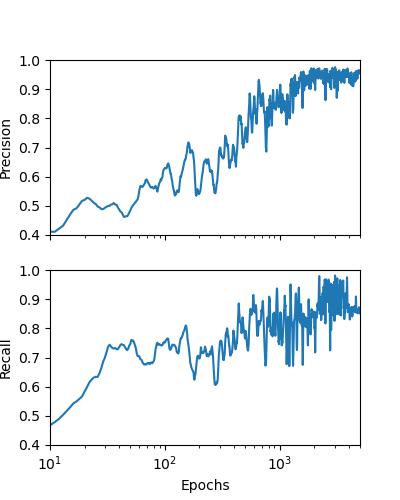

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
moving_window = 25

axs[0].plot(np.convolve(TLNN_results['   metrics/precision(B)'], np.ones(moving_window)/moving_window, mode='valid'))
axs[1].plot(np.convolve(TLNN_results['      metrics/recall(B)'], np.ones(moving_window)/moving_window, mode='valid'))

axs[0].set_ylabel("Precision")
axs[1].set_ylabel("Recall")

axs[1].set_xlabel("Epochs")

for ax in axs:
    ax.set_xlim(10, 5000)
    ax.set_xscale('log')
    ax.set_ylim((0.4, 1))


In [44]:
TLNN_results = pd.read_csv(r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\TLNN\results_large.csv")

In [45]:
TLNN_results.keys()

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

In [47]:
print(TLNN_results['metrics/precision(B)'].max())
print(TLNN_results['metrics/recall(B)'].max())

0.73144
0.6515


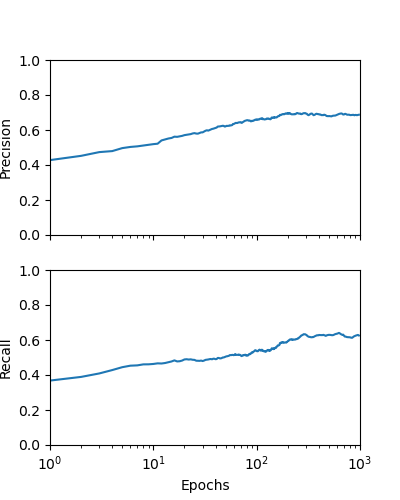

In [46]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
moving_window = 25
axs[0].plot(np.convolve(TLNN_results['metrics/precision(B)'], np.ones(moving_window)/moving_window, mode='valid'))
axs[1].plot(np.convolve(TLNN_results['metrics/recall(B)'], np.ones(moving_window)/moving_window, mode='valid'))

axs[0].set_ylabel("Precision")
axs[1].set_ylabel("Recall")

axs[1].set_xlabel("Epochs")

for ax in axs:
    ax.set_xlim(1, 1000)
    ax.set_xscale('log')
    ax.set_ylim((0, 1))


In [35]:
CCNN_results = pd.read_csv(r"C:\Users\fhacesga\OneDrive - University Of Houston\000_FIRMsPaper\CCNN\results.csv")

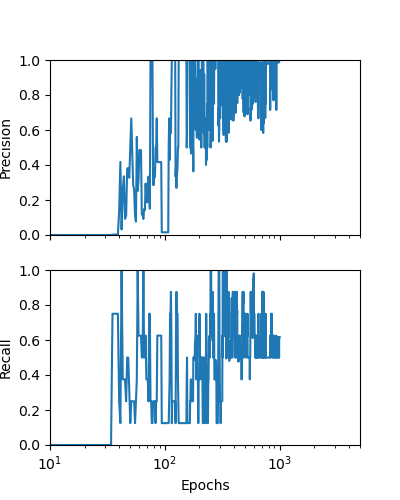

In [40]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
moving_window = 25
#axs[0].plot(np.convolve(CCNN_results['metrics/precision(B)'], np.ones(moving_window)/moving_window, mode='valid'))
#axs[1].plot(np.convolve(CCNN_results['metrics/recall(B)'], np.ones(moving_window)/moving_window, mode='valid'))
axs[0].plot(CCNN_results['metrics/precision(B)'])
axs[1].plot(CCNN_results['metrics/recall(B)'])

axs[0].set_ylabel("Precision")
axs[1].set_ylabel("Recall")

axs[1].set_xlabel("Epochs")

for ax in axs:
    ax.set_xlim(10, 5000)
    ax.set_xscale('log')
    ax.set_ylim((0, 1))


In [42]:
print(np.max(np.convolve(CCNN_results['metrics/precision(B)'], np.ones(moving_window)/moving_window, mode='valid')))
print(np.max(np.convolve(CCNN_results['metrics/recall(B)'], np.ones(moving_window)/moving_window, mode='valid')))

0.9969228000000001
0.8345032000000001


In [24]:
for b in tiled_yolo_model_paths:

    detection_model = AutoDetectionModel.from_pretrained(
        model_type="yolov8",
        model_path=b,
        confidence_threshold=0.001,
        device="cuda",  # or 'cuda:0'
    )

    print(b, len(torch.nn.utils.parameters_to_vector(detection_model.model.parameters())))

C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\CORNERS\CornersTiled_111324.pt 20057634
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FANN\FANN_large_YOLO.pt 25311251
